![](https://cdn-images-1.medium.com/max/853/1*DgFPLm5TKXuKnNUlYCE2DQ.jpeg)

<div align='left'><font size='5' color='#5b2c6f '> Purpose of this notebook</font></div>

- In this notebook we will discuss about class imbalance problem which is occus often more in problems like fraudulent transaction identification and
  spam  identification .
- Discuss and implement methods to solve this issue to an extend.
- [Loading Libraries](#1)
- [Loading Data ](#2)
- [The metric trap](#3)
- [Data preparating](#4)
- [Resampling](#5)
- [Resampling using sklearn](#6)
- [Dimensionality Reduction and Clustering](#7)
- [Python imbalanced-learn module](#8)
- [Algorithmic Ensemble Techniques](#9)

### [Loading Required libraries](#1)<a id="1"></a> <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

## [Loading Data](#2)<a id="2"></a> <br>

In [2]:
%%time 
train_transactions=pd.read_csv('../input/train_transaction.csv')
train_identity=pd.read_csv('../input/train_identity.csv')
print('Train data set is loaded !')

Train data set is loaded !
CPU times: user 24.3 s, sys: 3.22 s, total: 27.6 s
Wall time: 27.8 s


<div align='left'><font size='4' color='#229954'>Getting basic Idea</font></div>

In [3]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

<div align='left'><font size='4' color='#229954'>Target variable</font></div>


Text(0.5, 1.0, 'Target variable count')

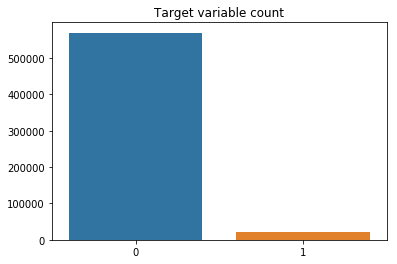

In [6]:
x=train_transactions['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

- There is clearly a class imbalace problem.
- We will look into methods of solving this issue later in this notebook.

## [The metric trap](#3)<a id="3"></a> <br>

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.


    False Positive. Predict an event when there was no event.
    False Negative. Predict no event when in fact there was an event.

   In the overview of the problem statement the organizers has described a situation where you stand at the queue for a long time and when your chance arrives,the transaction gets denied because it was interpreted as a Fraudulent transaction which many of us have faced.
 This is classical example of **False Negative** prediction.
 


**Change the performance metric**

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:

**Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.
    
**Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
    
**Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
    
**F1 Score**: the weighted average of precision and recall.
    

I don't understand why the competition hosts selected ROC_AUC as evaluation metric,I think
- ROC curves should be used when there are roughly equal numbers of observations for each class.
-  Precision-Recall curves should be used when there is a moderate to large class imbalance.


## [Merging transaction and identity dataset](#4)<a id="4"></a> <br>

We will firt merge our **transactions** and **identity** datasets.

In [7]:
train=train_transactions.merge(train_identity,how='left',left_index=True,right_index=True)
y_train=train['isFraud'].astype('uint8')
print('Train shape',train.shape)



del train_transactions,train_identity

print("Data set merged ")



Train shape (590540, 435)
Data set merged 


<div align='left'><font size='4' color='#229954'>Reducing memory usage</font></div>



In [8]:


%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [9]:


%%time
train = reduce_mem_usage2(train)




Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.1%
CPU times: user 58.3 s, sys: 1min 12s, total: 2min 10s
Wall time: 2min 11s


<div align='left'><font size='4' color='#229954'>Splitting to train and validation</font></div>


- We will now split the train dataset into train and validation set.
- We will keeep 20% of data for validation.

In [10]:
X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),y_train,test_size=.2,random_state=1)


## [Resampling](#5)<a id="5"></a> <br>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

## [Resampling Techniques using sklearn](#6)<a id="6"></a> <br>

<div align='left'><font size='4' color=' #6c3483'> 1.Oversample minority class </font></div>


Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [11]:
X=pd.concat([X_train,y_train],axis=1)


not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()



1    455903
0    455903
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

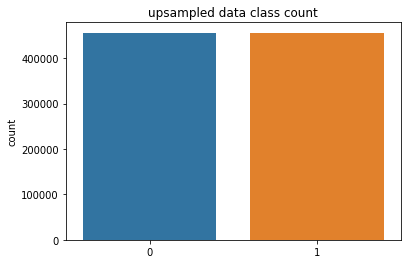

In [12]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

<div align='left'><font size='4' color=' #6c3483'>  2. Undersample majority class </font></div>


Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [13]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

1    16529
0    16529
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

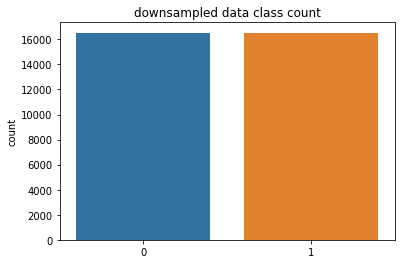

In [14]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('downsampled data class count')
plt.ylabel('count')

We will review other resampling techniques.



For ease of visualization, let's create a small unbalanced sample dataset using the make_classification method:


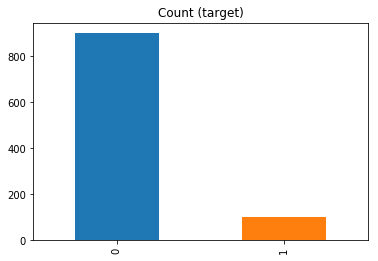

In [15]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')

- We will do an experiment with this data without any resampling technique.
- We will fit and predict the data on a Logistic regression model and observe the output scores.

In [16]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [17]:
probs,y_test=logistic(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- We will define two functions to plot precision_recall curve and roc curve

In [18]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

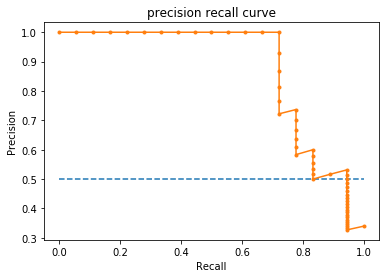

In [19]:
plot_pre_curve(y_test,probs)

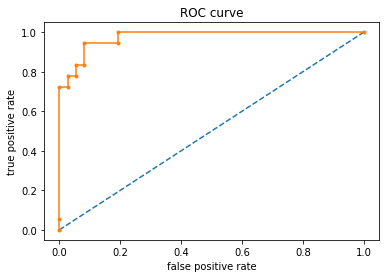

In [20]:
plot_roc(y_test,probs)



We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:


In [21]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()






## [Dimensionality Reduction and Clustering](#7)<a id="7"></a> <br>

Understanding t-SNE:
In order to understand this algorithm you have to understand the following terms:

    Euclidean Distance
    Conditional Probability
    Normal and T-Distribution Plots



In the below section we will implement three major dimensionality reduction algorithms
- **T-sne**
- **PCA**
- **Truncated SVD**

In [22]:

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.4 s
PCA took 0.064 s
Truncated SVD took 0.0026 s


Now we will visualize the output of the above three algorithms in a 2D space.

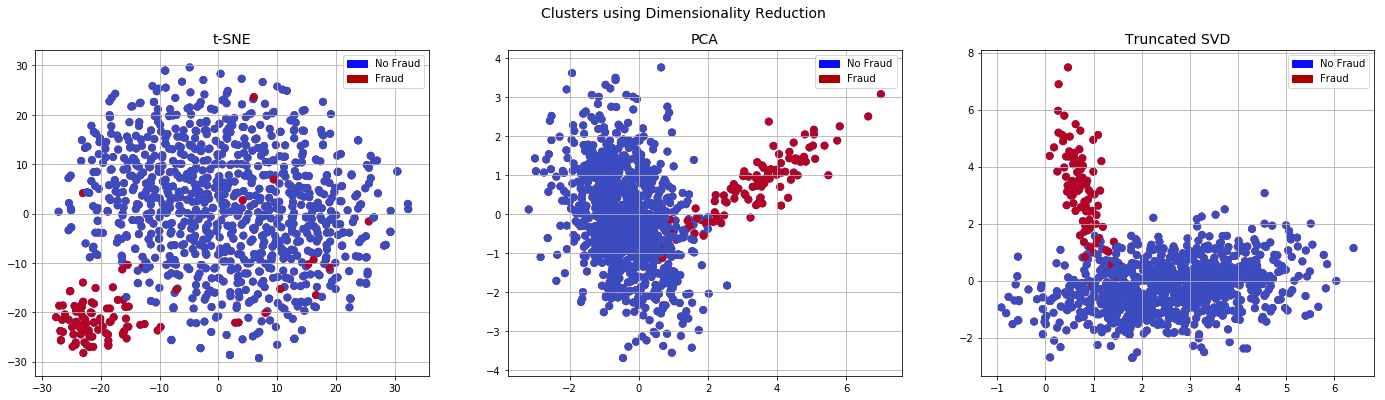

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()



## [Python imbalanced-learn module](#8)<a id='8'></a></br>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.


In [24]:
import imblearn

Using TensorFlow backend.


<div align='left'><font size='4' color=' #6c3483'>  Random under-sampling  with imbalanced-learn </font></div>



The number of removed indices are  200


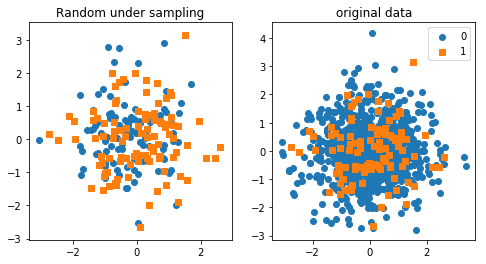

In [25]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler(return_indices=True) ##intialize to return indices of dropped rows
X_rs,y_rs,dropped = ran.fit_sample(X,y)

print("The number of removed indices are ",len(dropped))
plot_2d_space(X_rs,y_rs,X,y,'Random under sampling')


- Let's try fit and predict on this data and observe the outcome.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


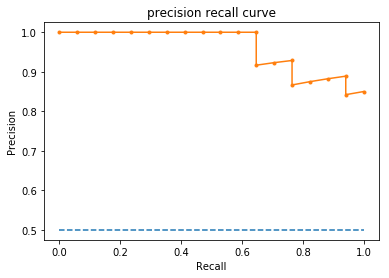

In [26]:
probs,y_test=logistic(X_rs,y_rs)
plot_pre_curve(y_test,probs)

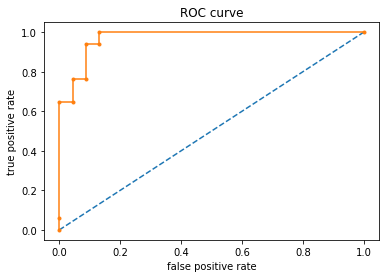

In [27]:
plot_roc(y_test,probs)

<div align='left'><font size='4' color=' #6c3483'>  Random over-sampling  with imbalanced-learn </font></div>



The new data contains 1800 rows 


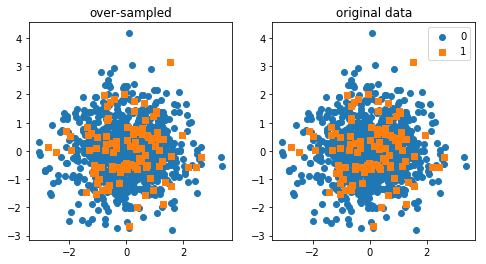

In [28]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran,y_ran= ran.fit_resample(X,y)

print('The new data contains {} rows '.format(X_ran.shape[0]))

plot_2d_space(X_ran,y_ran,X,y,'over-sampled')


Let's try fit and predict on this data and observe the outcome.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


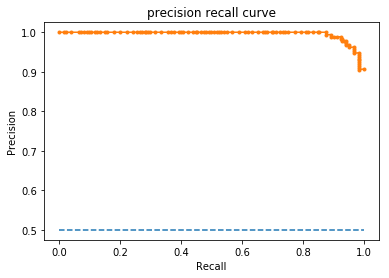

In [29]:
probs,y_test=logistic(X_ran,y_ran)
plot_pre_curve(y_test,probs)

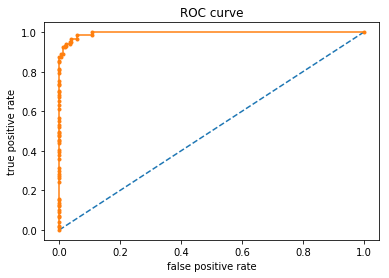

In [30]:
plot_roc(y_test,probs)


## [Under-sampling: Tomek links](#9)

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

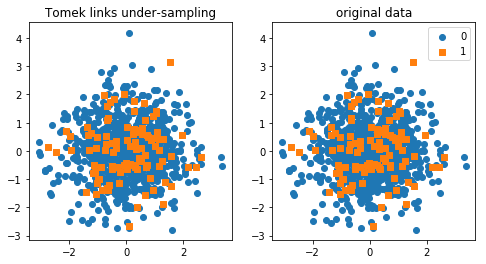

In [31]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl,X,y, 'Tomek links under-sampling')

In [ ]:
probs,y_test=logistic(X_tl,y_tl)
plot_pre_curve(y_test,probs)

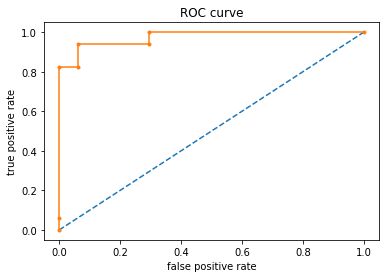

In [33]:
plot_roc(y_test,probs)

<div align='left'><font size='4' color=' #6c3483'>  Over-sampling: SMOTE </font></div>







SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)


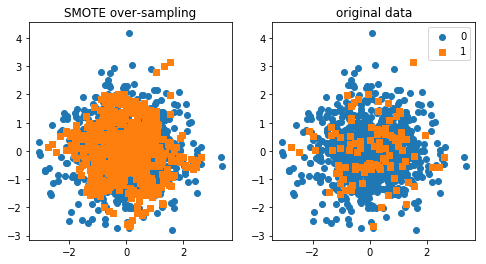

In [34]:


from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')



Let's try fit and predict on this data and observe the outcome.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


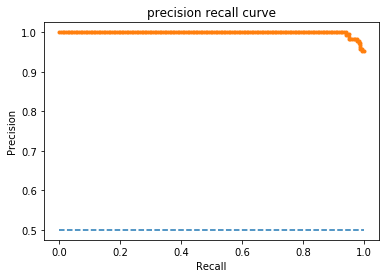

In [35]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

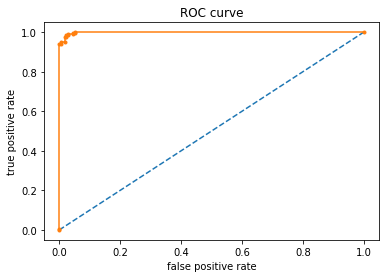

In [36]:
plot_roc(y_test,probs)

## [Algorithmic Ensemble Techniques](#9)<a id="1"></a> <br>
The above section, deals with handling imbalanced data by resampling original data to provide balanced classes. In this section, we are going to look at an alternate approach i.e.  Modifying existing classification algorithms to make them appropriate for imbalanced data sets.

The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their prediction

![ Approach to Ensemble based Methodologies](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/03/16142904/ICP4.png)

<div align='left'><font size='4' color=' #6c3483'>  XGBoost </font></div>



![](https://miro.medium.com/max/1400/1*FLshv-wVDfu-i54OqvZdHg.png)

XGBoost (Extreme Gradient Boosting) is an advanced and more efficient implementation of Gradient Boosting Algorithm discussed in the previous section.

Advantages over Other Boosting Techniques

It is 10 times faster than the normal Gradient Boosting as it implements parallel processing. It is highly flexible as users can define custom optimization objectives and evaluation criteria, has an inbuilt mechanism to handle missing values.
Unlike gradient boosting which stops splitting a node as soon as it encounters a negative loss, XG Boost splits up to the maximum depth specified and prunes the tree backward and removes splits beyond which there is an only negative loss.

Extreme gradient boosting can be done using the XGBoost package in R and Python

### WORK IN PROGRESS
<div align='left'><font size='5' color=' #a93226 '>  If you like my work,please do upvote ^ </font></div>



<div align='left'><font size='4' color=' #6c3483'> References </font></div>


- [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
- [Resampling strategies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)